In [1]:
import tensorflow as tf
tf.random.set_seed(1000)
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1000)

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re

import json
from os import listdir
from os import walk
from os.path import isfile, join
import random

import tensorflow.keras as keras

In [2]:
import segmentation_service
%matplotlib inline

Selected model:Mask R-CNN Inception ResNet V2 1024x1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1
loading model...
model loaded!


In [3]:
print('tensorflow {}'.format(tf.__version__))
print("keras {}".format(keras.__version__))
print("numpy {}".format(np.__version__))

tensorflow 2.5.0
keras 2.5.0
numpy 1.19.5


### Labels

In [4]:
labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"
downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []
i = 0
with open(downloaded_file) as f:
    labels = f.readlines()
    classes = [l.strip() for l in labels[1:]]
    i += 1
    
n_classes = len(classes)

sel_model = "resnet50"
model = tf.keras.applications.ResNet50(weights="imagenet")
last_conv_layer_name  = "conv5_block3_out"
latent_rep_layer_name = "avg_pool"

In [5]:
#input --> [(unflattened) last conv representation, output scores]
grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
)

#input --> [(flattened) last conv representation, output scores]
latent_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(latent_rep_layer_name).output, model.output]
)

In [6]:
#Auxiliary dictionaries to map class indices with labels and wordnet IDs.

imagenet_class_map = json.load(open("imagenet_class_index.json"))

wordnet2class = {}
wordnet2idx   = {}
idx2wordnet   = {}
for key in imagenet_class_map.keys():
    val = imagenet_class_map[key]
    cur_word , cur_class = val[0] , val[1].replace("_"," ")
    wordnet2class[cur_word] = cur_class
    assert cur_class==classes[int(key)] #Sanity check
    wordnet2idx[cur_word] = int(key)
    idx2wordnet[int(key)] = cur_word

### Auxiliary functions

In [7]:
#Loads an image (with the specified size) given a path
def get_img_array(img_path, size):
    img   = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = np.array(img)
    array = np.expand_dims(array, axis=0) #add batch dimension
    return array


#Given an input image, a model, the layer of the tensor corresponding to the (unflattened)
#conv layer, and a class index (pred_index), computes and returns the Grad-CAM saliency-map that
#explains the classification of the model.
#If no class is specified (i.e., if pred_index==None) then the predicted class will be considered
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None, out_npy=True):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    #Gradient of the selected class w.r.t last conv layer activations.
    #If no class is specified (i.e., if pred_index==None) then the predicted class will be considered
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    #Average intensities of the gradient for every feature map (=~"relevances")
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    #Weighted combination of the feature maps
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    #ReLU + normalization in range [0,1]
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    if out_npy: return heatmap.numpy()
    else:       return heatmap


#Creates and returns a colored saliency map.
def get_plottable_map(heatmap):
    heatmap_ = np.copy(heatmap)
    heatmap_ = np.uint8(255 * heatmap_)
    jet = cm.get_cmap("jet")
    jet_colors  = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((224,224))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    jet_heatmap = np.array(jet_heatmap,dtype=np.int16)
    return jet_heatmap


#Plot the image (plot_img) with the top "plot_n_classes" and the corresponding conference scores. 
def plot_with_confidences(plot_img, predictions, classes=classes, plot_n_classes=3, savepath=None, figsize=None):
    
    class_idxs_sorted = np.argsort(predictions.numpy().flatten())[::-1]
    cur_title = "\n".join(["%s: %.3f"%(classes[idx], predictions[0,idx]) for idx in class_idxs_sorted[0:plot_n_classes]])
    
    plt.imshow(plot_img)
    plt.title(cur_title, loc="left")
    plt.axis("off")
    
    if not (figsize  is None):
        plt.gcf().set_size_inches(figsize)
        
    if not (savepath is None): 
        plt.savefig(savepath, dpi=600, bbox_inches="tight")
    plt.show()

    
#Plot the provided input image (plot_img) overlaying the saliency-map ("plot_heatmap"). Alpha controls the
#transparency of the saliency-map.
def plot_img_with_saliency(plot_img, plot_heatmap, alpha=0.6, savepath=None, figsize=None, jet=cm.get_cmap("jet")):
    plot_heatmap = np.uint8(255 *np.copy(plot_heatmap)) # Rescale heatmap to a range 0-255
    jet_colors   = jet(np.arange(256))[:, :3] # Use RGB values of the colormap
    jet_heatmap  = jet_colors[plot_heatmap]
    jet_heatmap  = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap  = jet_heatmap.resize((224,224))
    jet_heatmap  = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    plt.imshow(plot_img)
    plt.imshow(np.array(jet_heatmap,dtype=np.int16),alpha=0.6)
    plt.axis("off")
    
    if not (figsize  is None):
        plt.gcf().set_size_inches(figsize)
        
    if not (savepath is None): 
        plt.savefig(savepath, dpi=600, bbox_inches="tight")
        
    plt.show()


#Prototype-based explanation.
#Given an input image "img" and the class of interest "target_class_idx" (e.g., the class predicted by the model),
#the function finds the closest "knn" number of inputs in the training set
#corresponding to the class "target_class_idx". The distances between inputs are measured as the L2 norm
#in the latent representation of the model. 
def get_knn(latent_model, img, source_class_idx, target_class_idx, wordnet_code, knn, 
            only_correct=False, save_name="/tmp/knn.pdf", plot_size=(5,3),
            root_dir="datasets/ILSVRC2012_img_train/"):
    
    #Compute the latent representation of the input image
    latent_rep, main_pred = latent_model(img)
    
    #Folder of the dataset containing the training inputs of the specified class
    img_folder = root_dir + wordnet_code + "/"
    #Load the filenames
    onlyfiles  = np.array([f for f in listdir(img_folder) if isfile(join(img_folder, f))])

    n_pictures    = len(onlyfiles) #number of instances in the training subset
    print("Searching %d pictures"%n_pictures)
    rep_distances = np.ones(n_pictures)*np.inf  #vector to store the L2 distances
    fool_mask     = np.zeros(n_pictures,dtype=np.int16) #auxiliary vector
    img_names     = []
    
    for i,f in enumerate(onlyfiles):
        #Load and preprocess the current image
        final_path = img_folder + f
        cur_img = keras.preprocessing.image.load_img(final_path, target_size=(224,224))
        cur_img = np.array(cur_img)
        cur_img = cur_img.reshape((1, *cur_img.shape))
        #Compute the latent representation
        cur_rep, cur_pred = latent_model(cur_img)
        
        #Compute the L2 difference
        if only_correct and np.argmax(cur_pred)==target_class_idx:
            rep_distances[i] = np.linalg.norm(latent_rep.numpy()[0] - cur_rep)
            fool_mask[i] = 1
            img_names.append(final_path)
        elif (not only_correct):
            rep_distances[i] = np.linalg.norm(latent_rep.numpy()[0] - cur_rep)
            fool_mask[i] = 1
            img_names.append(final_path)

    if only_correct:
        #Filter only those inputs which are correctly classified by the model
        filtered_idx  = np.where(fool_mask==1)[0]
        rep_distances = np.copy(rep_distances[filtered_idx])
    else:
        assert np.all(fool_mask==1) #sanity check

    #Closest indices
    top_knn = np.argsort(rep_distances)[:knn]

    #Plot the "knn" closest "prototypes"
    fig, axes = plt.subplots(1,knn,figsize=plot_size)
    for i,idx in enumerate(top_knn):
        f = img_names[idx]
        print(f)
        cur_img = keras.preprocessing.image.load_img(f, target_size=(224,224))
        cur_img = np.array(cur_img)
        axes[i].imshow(cur_img)
        axes[i].axis("off")        
    fig.tight_layout(pad=0.2)
    if not (save_name is None): plt.savefig(save_name, dpi=600, bbox_inches="tight")
    plt.show()
        
    print("-------------------")

# Attacks against feature-attribution based explanations

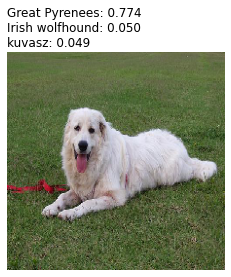

In [8]:
main_img_name = "dog_white"  #Fig. 2
#main_img_name = "dog_suit"  #Fig. 3

if main_img_name=="dog_white":
    img_file = "datasets/val_blurred/n02111500/ILSVRC2012_val_00035941.jpg"
    target_class_set = [222, 270, 208] #--> 222-kuvasz, 270-white wolf, 208-Labrador retriever 
elif main_img_name=="dog_suit":
    img_file = "datasets/val_blurred/n02099429/ILSVRC2012_val_00010328.jpg"
    target_class_set = [206, 834, 221] #--> 206-curly-coated retriever (source), 834-suit, 221-Irish water spaniel
else:
    sys.exit("")

_img = keras.preprocessing.image.load_img(img_file,target_size=(224,224))

#Prediction
img = np.copy(np.array(_img))
img = img.reshape((1, *img.shape))
y_pred = model(img, training=False)
source_class = int(np.argmax(y_pred))

#Plot the clean input and the top-3 classes (with the corresponding confidence scores)
plot_with_confidences(img[0], y_pred, figsize=(4,4), savepath="/tmp/original_%s.pdf"%main_img_name)

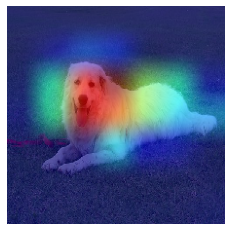

In [9]:
#Create and plot the saliency-map explanation (over the original image)
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)
plot_img_with_saliency(img[0], heatmap, figsize=(4,4), savepath="/tmp/original_exp_%s.pdf"%main_img_name)

# Generate the adversarial examples

In [10]:
def generate_adversarial(model, img, target_class_onehot, source_map, target_map, 
                         eps=6.0, step_size=0.1, n_iters=60, tradeoff_param=0.5):
    img_ = np.copy(img)
    src_img_copy = np.copy(np.array(img_,dtype=np.float32)) #backup copy of the original image
    #Initialize the adversarial example
    convert_img = img_ + (step_size/1.0e4)*np.random.rand(img_.shape[0],img_.shape[1],img_.shape[2],img_.shape[3])
    cur_adv = tf.Variable(convert_img, dtype=tf.float32)  
    
    heatmap = tf.Variable(np.zeros(target_map.shape))
    target_class = np.argmax(target_class_onehot)
    
    for i in range(n_iters):
        with tf.GradientTape() as main_tape:
            #CROSS-ENTROPY LOSS
            cur_pred    = model(cur_adv, training=False)
            loss_cce    = tf.keras.losses.CategoricalCrossentropy()
            loss_cce_ev = loss_cce(target_class_onehot, cur_pred[0])

            if np.argmax(cur_pred)!=target_class:
                #First we will optimize the perturbation only to produce the desired target class
                final_loss = loss_cce_ev
            else:
                #Maximize the confidence in the target class + minimize the distance with the target explanation
                with tf.GradientTape() as tape:
                    #Compute the activations of the last conv layer + the output
                    last_conv_layer_output, preds = grad_model(cur_adv)
                    class_channel = preds[:, target_class]

                #Gradient of the output w.r.t. to the last representation layer (last conv. layer)
                grads = tape.gradient(class_channel, last_conv_layer_output)
                #Average intensities of the gradient for every feature map (=~"relevances")
                pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
                #Weighted combination of the feature maps
                last_conv_layer_output = last_conv_layer_output[0]
                heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
                heatmap = tf.squeeze(heatmap)
                #ReLU + normalization in range [0,1]
                heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
                
                #Compute the L2 norm as the explantion loss
                exp_diff_loss = tf.norm(target_map-heatmap,ord="euclidean")
                
                #Final loss (Cross-Entropy + L2-loss of feature maps)
                final_loss    = loss_cce_ev*(1.0-tradeoff_param) + exp_diff_loss*tradeoff_param

                #Print the losses to check the process
                #print("Class loss: %.5f   ||  Expl loss: %.5f"%(loss_cce_ev,exp_diff_loss))


        #Compute the gradients
        cur_grads_opt = main_tape.gradient(final_loss, cur_adv)
        #Perturb the input (PGD)
        cur_adv = cur_adv - tf.sign(cur_grads_opt)*step_size
        cur_adv = tf.clip_by_value(cur_adv, src_img_copy-eps, src_img_copy+eps) #Bound perturbation norm
        cur_adv = tf.clip_by_value(cur_adv, 0.0, 255.0) #valid image

        #print("Pred: %d (conf: %.3f)"%(np.argmax(cur_pred),np.max(cur_pred)))

        cur_adv = tf.Variable(cur_adv, dtype=tf.float32)
        
    return cur_adv

Top 5 classes (clean): [257 170 222 216 267]
Top 5 classes (clean): ['Great Pyrenees' 'Irish wolfhound' 'kuvasz' 'clumber' 'standard poodle']
Confidences   (clean): [0.77431196 0.0502731  0.04898911 0.03043123 0.02887927]



Target class: kuvasz
Top 5 classes (adversarial): [222 267 228 202 257]
Top 5 classes (adversarial): ['kuvasz' 'standard poodle' 'komondor' 'soft-coated wheaten terrier'
 'Great Pyrenees']
Confidences   (adversarial): [9.8100340e-01 1.2155377e-02 3.5519933e-03 1.0644644e-03 5.3059403e-04]


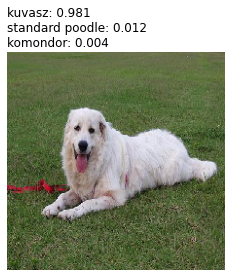

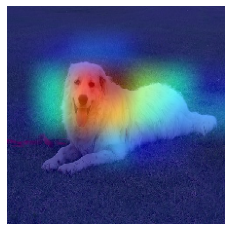

Target class: white_wolf
Top 5 classes (adversarial): [270 258 296 260 257]
Top 5 classes (adversarial): ['white wolf' 'Samoyed' 'ice bear' 'chow' 'Great Pyrenees']
Confidences   (adversarial): [0.95616287 0.0209897  0.00599169 0.00429191 0.0025837 ]


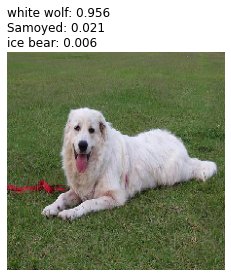

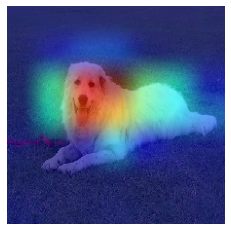

Target class: Labrador_retriever
Top 5 classes (adversarial): [208 254 207 170 202]
Top 5 classes (adversarial): ['Labrador retriever' 'pug' 'golden retriever' 'Irish wolfhound'
 'soft-coated wheaten terrier']
Confidences   (adversarial): [0.9737221  0.00642065 0.00285239 0.00214131 0.00198631]


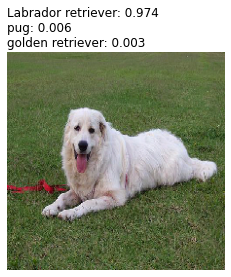

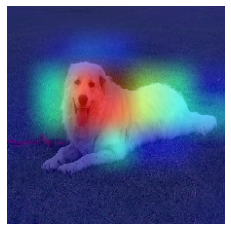

In [11]:
pred = model(img, training=False) #clean prediction
class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1] #order classes
print("Top 5 classes (clean):", class_idxs_sorted[0:5]) #top 5 classes (Index)
print("Top 5 classes (clean):", np.array(classes)[class_idxs_sorted[0:5]]) #top 5 classes (Readable)
print("Confidences   (clean):", pred.numpy()[0, class_idxs_sorted[0:5]]) #confidence corresponding to the first 5 classes
print("\n\n")

source_class = np.argmax(pred)
source_map = make_gradcam_heatmap(img, model, last_conv_layer_name, pred_index=source_class, out_npy=False)

tf.random.set_seed(1000)
np.random.seed(1000)

#Attack parameters
eps_val       = 6.0
step_size_val = 0.1
n_iters_val   = 60

for target_class in target_class_set:

    short_name = "_".join(re.split('[ -]', classes[target_class]))
    print("Target class:", short_name)

    target_class_onehot = np.zeros(n_classes)
    target_class_onehot[target_class] = 1.0
    target_class_onehot = tf.Variable(target_class_onehot, dtype=tf.float32)

    if main_img_name=="dog_suit":
        #Create the target saliency maps by segmenting the image using a DNN
        segmentation = segmentation_service.segment_image(image_path=img_file)
        seg_masks    = segmentation.get('detection_masks_reframed', None)
        suit_class_idx = np.where(np.array(classes)=="suit")[0][0]
        #The mask at 0 position corresponds to the suit, the one at 1 position to the dog.
        target_map_up  = np.copy(seg_masks[1,:]) if target_class!=suit_class_idx else np.copy(seg_masks[0,:])
        target_map     = np.asarray(Image.fromarray(target_map_up).resize((7,7)))
    elif main_img_name=="dog_white":
        #In this case we will use the original saliency-map as the target explanation
        target_map  = make_gradcam_heatmap(img, model, last_conv_layer_name, pred_index=source_class, out_npy=False)

    assert np.all(target_map)>=0.0 and np.all(target_map)<=1.0 #sanity check
    
    
    #Generate the adversarial example
    cur_adv = generate_adversarial(model, img, target_class_onehot,
                                   source_map, target_map,
                                   eps=eps_val, step_size=step_size_val, n_iters=n_iters_val)

    #Ensure a valid image format
    cur_adv_round = np.uint8(tf.clip_by_value(tf.round(cur_adv),0,255).numpy())
    
    adv_pred = model(tf.clip_by_value(tf.round(cur_adv), 0, 255), training=False)
    class_idxs_sorted = np.argsort(adv_pred.numpy().flatten())[::-1]
    print("Top 5 classes (adversarial):", class_idxs_sorted[0:5])
    print("Top 5 classes (adversarial):", np.array(classes)[class_idxs_sorted[0:5]])
    print("Confidences   (adversarial):", adv_pred.numpy()[0, class_idxs_sorted[0:5]])

    #Sanity checks
    pred_check = model(tf.Variable(cur_adv_round, dtype=tf.float32), training=False)
    assert np.all(np.abs(adv_pred-pred_check)<1e-8)
    assert np.all(adv_pred==pred_check), np.max(np.abs(adv_pred-pred_check))
    assert np.all(np.float32(np.uint8(cur_adv_round))==cur_adv_round) #the rounding of tf is correct
    assert np.all(tf.Variable(cur_adv_round, dtype=tf.float32)-tf.clip_by_value(tf.round(cur_adv),0,255)<1e-8)
    
    
    plot_with_confidences(cur_adv_round[0], adv_pred, figsize=(4,4), savepath="/tmp/adv_%s_%s.pdf"%(main_img_name, short_name))

    heatmap = make_gradcam_heatmap(tf.Variable(cur_adv_round, dtype=tf.float32), model, last_conv_layer_name)
    plot_img_with_saliency(cur_adv_round[0], heatmap, figsize=(4,4), savepath="/tmp/adv_exp_%s_%s.pdf"%(main_img_name, short_name))

Class: Great Pyrenees
Searching 1300 pictures
datasets/ILSVRC2012_img_train/n02111500/n02111500_9017.JPEG
datasets/ILSVRC2012_img_train/n02111500/n02111500_6294.JPEG
datasets/ILSVRC2012_img_train/n02111500/n02111500_1903.JPEG


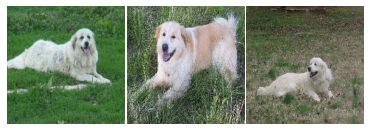

-------------------
Class: kuvasz
Searching 1300 pictures
datasets/ILSVRC2012_img_train/n02104029/n02104029_1287.JPEG
datasets/ILSVRC2012_img_train/n02104029/n02104029_5819.JPEG
datasets/ILSVRC2012_img_train/n02104029/n02104029_6330.JPEG


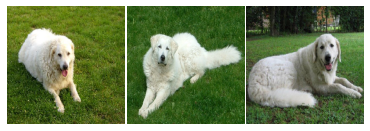

-------------------
Class: white wolf
Searching 1300 pictures
datasets/ILSVRC2012_img_train/n02114548/n02114548_1663.JPEG
datasets/ILSVRC2012_img_train/n02114548/n02114548_5830.JPEG
datasets/ILSVRC2012_img_train/n02114548/n02114548_2974.JPEG


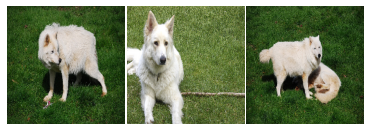

-------------------
Class: Labrador retriever
Searching 1300 pictures
datasets/ILSVRC2012_img_train/n02099712/n02099712_7784.JPEG
datasets/ILSVRC2012_img_train/n02099712/n02099712_4854.JPEG
datasets/ILSVRC2012_img_train/n02099712/n02099712_4543.JPEG


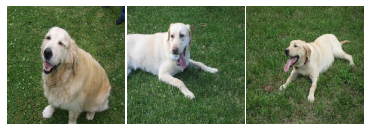

-------------------


In [12]:
#Plot some prototype-based explanations for illustration purposes

if main_img_name=="dog_white":
    #Get the closest "prototypes" belonging to the source class, for the original input
    print("Class:", classes[source_class])
    get_knn(latent_model, img, source_class, source_class, idx2wordnet[source_class], 3, False,
            save_name ="/tmp/knn_%s_%s.pdf"%(main_img_name,classes[source_class]), 
            root_dir="datasets/ILSVRC2012_img_train/")
    #Get the closest "prototypes" belonging to each target class, for the original input
    for target_class in target_class_set:
        print("Class:", classes[target_class])
        wordnet_code  = idx2wordnet[target_class]
        cur_classname = wordnet2class[wordnet_code]
        get_knn(latent_model, img, source_class, target_class, wordnet_code, 3, False,
                save_name ="/tmp/knn_%s_%s.pdf"%(main_img_name,cur_classname), 
                root_dir="datasets/ILSVRC2012_img_train/")
    
if main_img_name=="dog_suit":
    #Get the closest "prototypes" belonging to the source class, for the original input
    print("Class:", classes[source_class])
    get_knn(latent_model, img, source_class, source_class, idx2wordnet[source_class], 3, False,
        save_name ="/tmp/knn_%s_%s.pdf"%(main_img_name,classes[source_class]), 
        root_dir="datasets/ILSVRC2012_img_train/")
    
    #Get the closest "prototypes" belonging to the target class "Irish water spaniel", for the original input
    target_class = 221  #Irish water spaniel
    print("Class:", classes[target_class])
    get_knn(latent_model, img, source_class, target_class, idx2wordnet[target_class], 3, False,
        save_name ="/tmp/knn_%s_%s.pdf"%(main_img_name,classes[target_class]), 
        root_dir="datasets/ILSVRC2012_img_train/")

# Attacks against prototype-based explanations

In [13]:
tf.random.set_seed(1000)
np.random.seed(1000)

In [14]:
source_class = 208
wordnet_code = idx2wordnet[source_class]
print("Source class:", source_class, classes[source_class], idx2wordnet[source_class])

target_class = 236
print("Target class:", target_class, classes[target_class], idx2wordnet[target_class])

Source class: 208 Labrador retriever n02099712
Target class: 236 Doberman n02107142


Top 5 classes (clean): ['Labrador retriever' 'Chesapeake Bay retriever'
 'American Staffordshire terrier' 'Weimaraner' 'Rottweiler']
Confidences   (clean): [0.949 0.03  0.006 0.005 0.003]


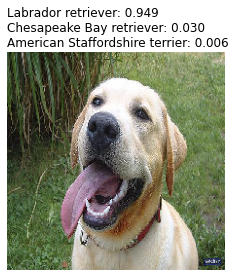

In [15]:
main_img_name ="lab5"

#Load the image
img_file = "datasets/val_blurred/n02099712/ILSVRC2012_val_00035360.jpg" #filename
_img = keras.preprocessing.image.load_img(img_file,target_size=(224,224))

img = np.array(_img)
img = img.reshape((1, *img.shape))

y_pred = model(img, training=False)
top_5 = tf.argsort(y_pred, axis=-1, direction="DESCENDING")[0][:5].numpy()
print("Top 5 classes (clean):", np.array(classes)[top_5])
print("Confidences   (clean):", np.round(y_pred.numpy()[0][top_5], 3))

assert source_class == int(np.argmax(y_pred)) #sanity check

#Plot the original input
plot_with_confidences(img[0], y_pred, figsize=(4,4), savepath="/tmp/original_%s.pdf"%main_img_name)

Searching 1300 pictures
datasets/ILSVRC2012_img_train/n02099712/n02099712_4885.JPEG
datasets/ILSVRC2012_img_train/n02099712/n02099712_7802.JPEG
datasets/ILSVRC2012_img_train/n02099712/n02099712_3197.JPEG


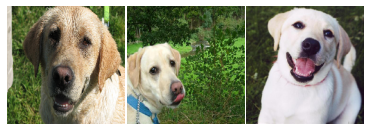

-------------------


In [16]:
#Prototype-based explanation for the original input (considering the source class)
get_knn(latent_model, img, source_class, source_class, idx2wordnet[source_class], 3, False,
        save_name ="/tmp/knn_clean_auto_%s.pdf"%(main_img_name), 
        root_dir="datasets/ILSVRC2012_img_train/")

datasets/ILSVRC2012_img_train/n02107142/n02107142_38297.JPEG


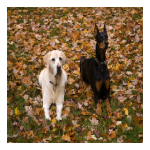

datasets/ILSVRC2012_img_train/n02107142/n02107142_4674.JPEG


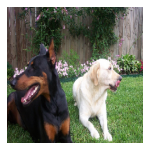

datasets/ILSVRC2012_img_train/n02107142/n02107142_56479.JPEG


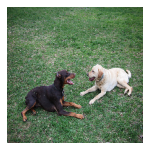

In [17]:
#Training images corresponding to the target class that will be set as the target explanation
proto_images_paths = ["datasets/ILSVRC2012_img_train/n02107142/n02107142_38297.JPEG",
                      "datasets/ILSVRC2012_img_train/n02107142/n02107142_4674.JPEG", 
                      "datasets/ILSVRC2012_img_train/n02107142/n02107142_56479.JPEG",
                     ]
    
for final_path in proto_images_paths:
    print(final_path)
    cur_img = keras.preprocessing.image.load_img(final_path, target_size=(224,224))
    cur_img = np.array(cur_img)
    plt.imshow(cur_img) ; plt.axis("off") ; plt.gcf().set_size_inches(2.5,2.5) ; plt.show()

In [18]:
#Compute the latent representation of the 3 images that will compose the target explanation
latent_list = []
for cur_path in proto_images_paths:
    print(cur_path)
    cur_img = keras.preprocessing.image.load_img(cur_path, target_size=(224,224))
    cur_img = np.array(cur_img)
    cur_img = cur_img.reshape((1, *cur_img.shape))
    cur_rep, cur_pred = latent_model(cur_img)
    latent_list.append(cur_rep[0])
    
target_latent = tf.stack(latent_list)

datasets/ILSVRC2012_img_train/n02107142/n02107142_38297.JPEG
datasets/ILSVRC2012_img_train/n02107142/n02107142_4674.JPEG
datasets/ILSVRC2012_img_train/n02107142/n02107142_56479.JPEG


In [19]:
def generate_adversarial_prototypes(model, img, target_class_onehot, target_latent, 
                                    eps=6.0, step_size=0.01, n_iters=60, tradeoff_param=0.75):
    img_ = np.copy(img)
    src_img_copy = np.copy(np.array(img_,dtype=np.float16))
    
    convert_img = img_ + (step_size/1.0e4)*np.random.rand(img_.shape[0],img_.shape[1],img_.shape[2],img_.shape[3])
    cur_adv = tf.Variable(convert_img, dtype=tf.float32)  
    
    target_class = np.argmax(target_class_onehot)
    
    for i in range(n_iters):
        with tf.GradientTape() as main_tape:
            cur_pred    = model(cur_adv, training=False)
            loss_cce    = tf.keras.losses.CategoricalCrossentropy()
            loss_cce_ev = loss_cce(target_class_onehot, cur_pred[0])

            if np.argmax(cur_pred)!=target_class:
                #Optimize only the prediction loss
                final_loss = loss_cce_ev
            else:
                #Optimize the prediction loss and the explanation loss jointly
                latent_rep, main_pred = latent_model(cur_adv)
                proto_loss = tf.reduce_mean(tf.norm(target_latent - latent_rep, axis=1))
                #Final loss (Cross-Entropy + L2-loss of feature maps)
                final_loss = loss_cce_ev*(1.0-tradeoff_param) + proto_loss*tradeoff_param
                #Print the losses to check the process
                #print("Class loss: %.5f   ||  Expl loss: %.5f"%(loss_cce_ev,proto_loss))

        #Compute the gradients
        cur_grads_opt = main_tape.gradient(final_loss, cur_adv)
        #Perturb the input (PGD)
        cur_adv = cur_adv - tf.sign(cur_grads_opt)*step_size
        #Constraints
        cur_adv = tf.clip_by_value(cur_adv, src_img_copy-eps, src_img_copy+eps) #Perturbation norm
        cur_adv = tf.clip_by_value(cur_adv, 0.0, 255.0) #valid image

        #print("%d, %d (%.3f)"%(i, np.argmax(cur_pred),np.max(cur_pred)))

        cur_adv = tf.Variable(cur_adv, dtype=tf.float32)
        
    return cur_adv

Target class: Doberman
Top 5 classes (adversarial): [236 209 168 208 178]
Top 5 classes (adversarial): ['Doberman' 'Chesapeake Bay retriever' 'redbone' 'Labrador retriever'
 'Weimaraner']
Confidences   (adversarial): [0.5283874  0.06616705 0.04687344 0.04257343 0.03298166]


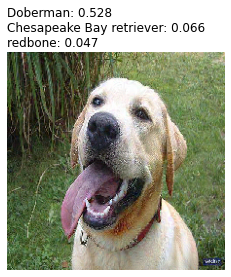

In [20]:
short_name = "_".join(re.split('[ -]', classes[target_class]))
print("Target class:", short_name)

#Generate a one-hot vector for the target class
target_class_onehot = np.zeros(n_classes)
target_class_onehot[target_class] = 1.0
target_class_onehot = tf.Variable(target_class_onehot, dtype=tf.float32)

#Generate the adversarial example
cur_adv = generate_adversarial_prototypes(model, img, target_class_onehot,
                                          target_latent, eps=16, step_size=0.1, n_iters=400)

#Ensure that satisfies image format
cur_adv_round = np.uint8(tf.clip_by_value(tf.round(cur_adv),0,255).numpy())

adv_pred = model(tf.clip_by_value(tf.round(cur_adv), 0, 255), training=False)
class_idxs_sorted = np.argsort(adv_pred.numpy().flatten())[::-1]
print("Top 5 classes (adversarial):", class_idxs_sorted[0:5])
print("Top 5 classes (adversarial):", np.array(classes)[class_idxs_sorted[0:5]])
print("Confidences   (adversarial):", adv_pred.numpy()[0, class_idxs_sorted[0:5]])
#Sanity checks
pred_check = model(tf.Variable(cur_adv_round, dtype=tf.float32), training=False)
assert np.all(np.abs(adv_pred-pred_check)<1e-8)
assert np.all(adv_pred==pred_check), np.max(np.abs(adv_pred-pred_check))
assert np.all(np.float32(np.uint8(cur_adv_round))==cur_adv_round) #the rounding of tf is correct


#Plot the adversarial example
plot_with_confidences(cur_adv_round[0], adv_pred, figsize=(4,4), savepath="/tmp/proto_adv_%s.pdf"%short_name)

In [21]:
#Given an input image "img" and the class of interest "wordnet code", the function returns
#the latent representation of the training inputs belonging to the class of interest. 
#Allows computing more efficiently the prototype-based explanation for multiple inputs (as the latent)
#representations of the class of interest are loaded only once.
def get_full_latent(latent_model, class_idx, wordnet_code, only_correct=False, latent_dim=2048,
                    root_dir="datasets/ILSVRC2012_img_train/"):
        
    #Folder containing the training images belonging to the specified class (by the "wordnet code")
    print(class_idx, wordnet_code)
    img_folder = root_dir + wordnet_code + "/"
    onlyfiles  = np.array([f for f in listdir(img_folder) if isfile(join(img_folder, f))])

    n_pictures    = len(onlyfiles) #number of training files belonging to the class of interest
    print("Searching %d pictures"%n_pictures) 
    rep_vec       = np.ones((n_pictures,latent_dim)) #vector to store the L2 distances
    fool_mask     = np.zeros(n_pictures, dtype=np.int16) #auxiliary vector
    img_names     = []
    
    for i,f in enumerate(onlyfiles):
        #Load the current training image
        final_path = img_folder + f
        cur_img = keras.preprocessing.image.load_img(final_path, target_size=(224,224))
        cur_img = np.array(cur_img)
        cur_img = cur_img.reshape((1, *cur_img.shape))
        
        cur_rep, cur_pred = latent_model(cur_img) #Compute the latent representation
        rep_vec[i,:] = np.copy(cur_rep) #Save the latent representation
        fool_mask = int(np.argmax(cur_pred)==class_idx) #Check whether the input is correctly classified by the model
        img_names.append(final_path)
        
    if only_correct:
        #Optional: filter those inputs incorrectly classified
        filtered_idx  = np.where(fool_mask==1)[0]
        rep_vec       = np.copy(rep_vec[filtered_idx,:])
        img_names     = np.copy(np.array(img_names)[filtered_idx])
        fool_mask     = np.copy(fool_mask[filtered_idx])

    return rep_vec, fool_mask, img_names

#Given the latent representation of the input (source_latent) and a matrix containing the latent representation
#of the prototypes (target_latent_mat, row-wise), returns the indices corresponding to the "knn_val" closest 
#prototypes, using as distance metric the euclidean distance in the latent space.
def plot_closest(source_latent, target_latent_mat, img_names, source_class, target_class, wordnet_code, 
                 knn_val, only_correct=False, save_name = None,  plot_size=(5,3),
                 root_dir="datasets/ILSVRC2012_img_train/"):
    
    n_images = target_latent_mat.shape[0] #Number of "prototypes"
    rep_distances = np.zeros(n_images) #vector to compute the L2 distances
    for i in range(n_images): 
        rep_distances[i] = np.linalg.norm(source_latent-target_latent_mat[i,:])
        
    #Closest indices
    top_knn = np.argsort(rep_distances)[:knn_val]

    #Plot the closest prototypes
    fig, axes = plt.subplots(1,knn_val,figsize=plot_size)
    for i,idx in enumerate(top_knn):
        f = img_names[idx]
        print(f)
        cur_img = keras.preprocessing.image.load_img(f, target_size=(224,224))
        cur_img = np.array(cur_img)
        axes[i].imshow(cur_img)
        axes[i].axis("off")        
    fig.tight_layout(pad=0.2)
    if not (save_name is None): plt.savefig(save_name, dpi=600, bbox_inches="tight")
    plt.show()

In [22]:
#Compute the latent representation of all the target classes 
full_latent_target, fool_mask, target_filenames = get_full_latent(latent_model, target_class, 
                                                                  idx2wordnet[target_class],
                                                                  root_dir="datasets/ILSVRC2012_img_train/")

236 n02107142
Searching 1300 pictures


datasets/ILSVRC2012_img_train/n02107142/n02107142_56853.JPEG
datasets/ILSVRC2012_img_train/n02107142/n02107142_12739.JPEG
datasets/ILSVRC2012_img_train/n02107142/n02107142_4674.JPEG


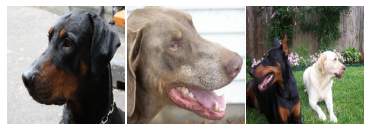

datasets/ILSVRC2012_img_train/n02107142/n02107142_4674.JPEG
datasets/ILSVRC2012_img_train/n02107142/n02107142_56479.JPEG
datasets/ILSVRC2012_img_train/n02107142/n02107142_38297.JPEG


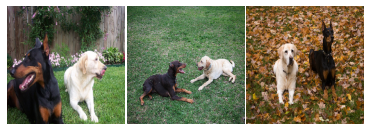

In [23]:
wordnet_code  = idx2wordnet[target_class]
cur_classname = wordnet2class[wordnet_code]

#Prototype-based explanation of the original input (with respect to the target class)
latent_rep, main_pred = latent_model(img)
plot_closest(latent_rep, full_latent_target, target_filenames, 
             source_class, target_class, wordnet_code, 3, False, 
             save_name ="/tmp/knn_clean_%s_%s.pdf"%(main_img_name,cur_classname), 
             root_dir="datasets/ILSVRC2012_img_train/")

#Prototype-based explanation of the adversarial example (with respect to the target class)
adv_round_latent_rep, adv_round_main_pred = latent_model(cur_adv_round)
plot_closest(adv_round_latent_rep, full_latent_target, target_filenames, 
             source_class, target_class, wordnet_code, 3, False, 
             save_name ="/tmp/knn_adv_round_%s_%s.pdf"%(main_img_name,cur_classname), 
             root_dir="datasets/ILSVRC2012_img_train/")